# EMNLP 2022
## Semantic Legal Searcher : Faster Natural Language-based Semantic Search for Case Law

In [ ]:
! pip install transformers
! pip install -U sentence-transformers
! pip install sentencepiece
! pip install faiss-gpu
! pip install pytrends
! pip install funcy pickle5

In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import pytrends
from pytrends.request import TrendReq
import datetime
from dateutil.relativedelta import relativedelta
import scipy.stats as stats

from sentence_transformers import SentenceTransformer, util

## 1. Legal Database (Original Korean Case Law)

In [5]:
# Load Legal Dataset(Get Only Judicial precedent data)
df = pd.read_csv('./data/law_cases(20220829).csv')
df = df.dropna(how='any')
# Make index for clustering
print(">> Judicial precedent data size : ",len(df))

df.head()

>> Judicial precedent data size :  62415


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm
0,압수물가환부불허결정에대한준항고일부인용결정에대한재항고,2020모735,20220630,400102.0,수사기관이 압수·수색영장에 적힌 ‘수색할 장소’에 있는 컴퓨터 등 정보처리장치에...,"헌법과 형사소송법이 구현하고자 하는 적법절차와 영장주의의 정신에 비추어 볼 때,...",【준항고인】 ○○○○○○○○○ 주식회사【변 호 인】 법무법인(유한) 화우 담당변호사...,83459,6591,0.655657
1,의사면허취소처분취소[의료법위반죄로 금고 이상의 형의 집행유예를 선고받은 자가 유예기...,2021두62171,20220630,400107.0,면허취소사유를 정한 구 의료법 제65조 제1항 단서 제1호의 ‘제8조 각호의 어...,"구 의료법(2016. 5. 29. 법률 제14220호로 개정되기 전의 것, 이하 ‘...","【원고, 상고인】 원고 (소송대리인 법무법인(유한) 원 담당변호사 이주웅 외 3인)...",83458,7709,0.768586
2,양수금[타인의 은행계좌로 송금한 금액이 착오송금임을 주장하며 그 수취은행을 상대로 ...,2016다237974,20220630,400101.0,[1] 예금거래기본약관에 따라 송금의뢰인이 수취인의 예금계좌에 자금이체를 하여 ...,"[1] 자금이체는, 은행 간 및 은행점포 간의 송금절차를 통하여 저렴한 비용으로...","【원고, 상고인】 주식회사 비엔씨 (소송대리인 법무법인 에이디엘 담당변호사 양창길 ...",83457,9245,0.923737
3,정산금등청구의소,2022다200089,20220630,400101.0,채권양수인이 양수채권을 자동채권으로 하여 채무자가 채권양수인에 대해 가지고 있던...,"민법 제493조 제2항은 ""상계의 의사표시는 각 채무가 상계할 수 있는 때에 대등액...","【원고, 상고인】 주식회사 티머니 (소송대리인 법무법인(유한) 충정 담당변호사 김성...",83456,1522,0.143636
4,무고,2022도3413,20220630,400102.0,무고죄의 성립요건 및 ‘형사처분을 받게 할 목적’의 인정 범위 / 무고죄의 고의...,무고죄는 타인으로 하여금 형사처분이나 징계처분을 받게 할 목적으로 신고한 사실이...,【피 고 인】 피고인【상 고 인】 피고인【변 호 인】 법무법인 케이앤비 담당변호사 ...,83455,272,0.017374


In [6]:
def text_len_plot(dataframe, col):
    """
    dataframe : DataFrame
    col : str(Column name)
    """
    dataframe['text_len'] = dataframe[col].apply(lambda words : len(words.split()))
    #dataframe['sent_len'] = dataframe[col].apply(lambda words : len(words.split(".")))
    mean_seq_len = np.round(dataframe['text_len'].mean() + dataframe['text_len'].std()).astype(int)
    #mean_sent_len = np.round(dataframe['sent_len'].mean() + dataframe['sent_len'].std()).astype(int)
    print(">> {} Average Text length : {}".format(col, mean_seq_len))
    print(">> {} Max Text length : {}".format(col, dataframe['text_len'].max()))
    print(">> {} Text words : {}".format(col, dataframe['text_len'].sum()))

    plt.figure(figsize=(12,6))
    sns.histplot(dataframe['text_len'], kde=True, color='royalblue', label='Text_length')
    plt.axvline(x=mean_seq_len, color='r', linestyle='--', label='max_length')
    plt.title('Text length'); plt.legend()
    plt.show()

>> judgment_issue Average Text length : 60
>> judgment_issue Max Text length : 611
>> judgment_issue Text words : 1872423


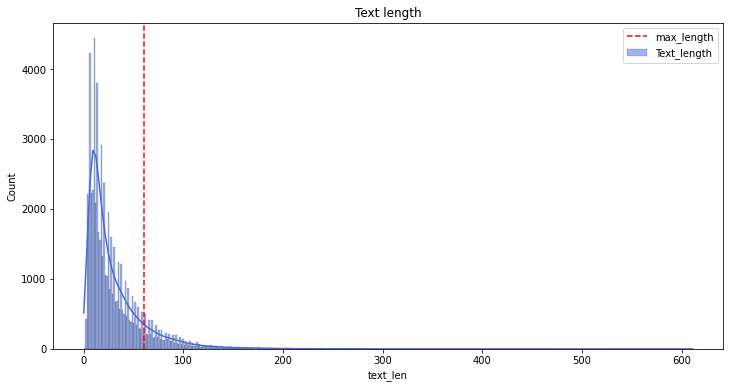

>> judgment_summary Average Text length : 209
>> judgment_summary Max Text length : 2849
>> judgment_summary Text words : 6432672


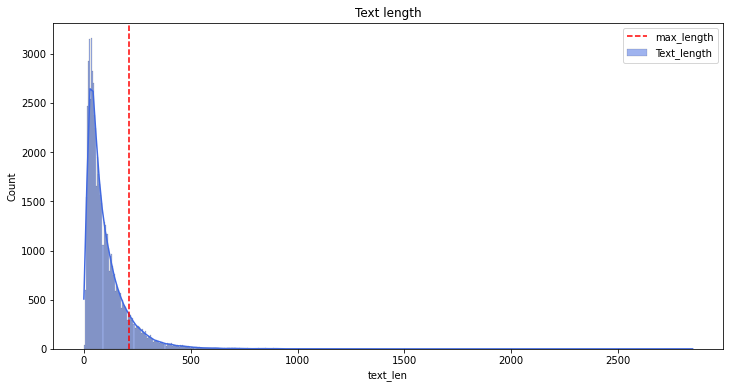

>> judgment_contents Average Text length : 1465
>> judgment_contents Max Text length : 37418
>> judgment_contents Text words : 41752381


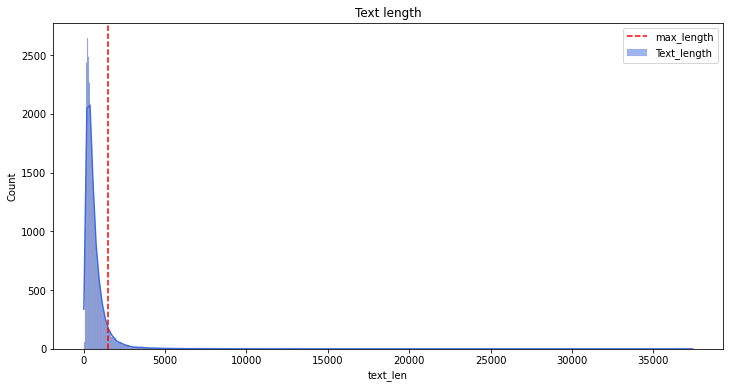

>> case_name Average Text length : 2
>> case_name Max Text length : 57
>> case_name Text words : 71434


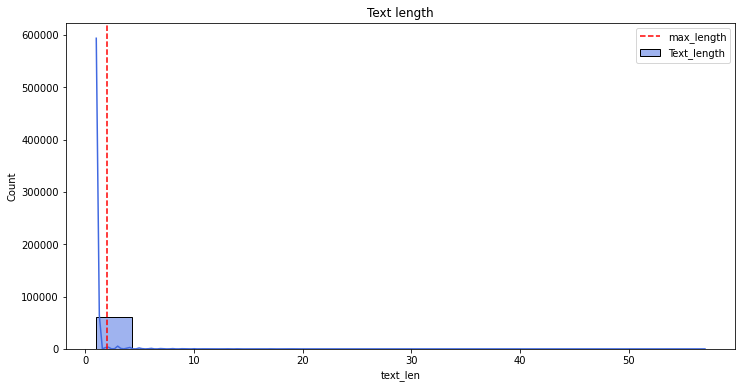

In [7]:
# Text Length
# 1. Judgment_issue
text_len_plot(df, 'judgment_issue')
# 2. judgment_summary
text_len_plot(df, 'judgment_summary')
# 3. judgment_full-text
text_len_plot(df, 'judgment_contents')
# 4. case_name
text_len_plot(df, 'case_name')

## STEP 1 : Load Pre-Trained Language model

In [8]:
# Load supervised or unsupervised fine-tuned models
my_model = './output/nil_sts_task_kolawbert'

## STEP 2 : Parallel Clustering-based Topic Modeling

In [9]:
from models.parallel_topic_model import *

In [10]:
target_column = 'judgment_summary'

cluster = ParallelCluster(
    dataframe = df,
    tgt_col = target_column,
    model_name = my_model,
    use_sentence_bert = True
    )

Batches:   0%|          | 0/1951 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62415, 768)


In [11]:
# 1. Parallel Embedding Clustering
clusters, unclusters = cluster.parallel_cluster(
    clusters = None,
    threshold = 0.78,
    page_size = 2500,
    iterations = 15
    )

=== Iteration 1 / 15 ===


>> Number of Total Clusters :  368
>> Percentage clusted Doc Embeddings : 14.39%


=== Iteration 2 / 15 ===


>> Number of Total Clusters :  701
>> Percentage clusted Doc Embeddings : 22.82%


=== Iteration 3 / 15 ===


>> Number of Total Clusters :  961
>> Percentage clusted Doc Embeddings : 27.38%


=== Iteration 4 / 15 ===


>> Number of Total Clusters :  1110
>> Percentage clusted Doc Embeddings : 29.27%


=== Iteration 5 / 15 ===


>> Number of Total Clusters :  1273
>> Percentage clusted Doc Embeddings : 31.19%


=== Iteration 6 / 15 ===


>> Number of Total Clusters :  1377
>> Percentage clusted Doc Embeddings : 32.26%


=== Iteration 7 / 15 ===


>> Number of Total Clusters :  1481
>> Percentage clusted Doc Embeddings : 33.34%


=== Iteration 8 / 15 ===


>> Number of Total Clusters :  1561
>> Percentage clusted Doc Embeddings : 34.11%


=== Iteration 9 / 15 ===


>> Number of Total Clusters :  1628
>> Percentage clusted Doc Embeddings : 34.71%


=== 

In [12]:
# 2. Stack : Stack the clustered results in order of cluster size
col_list = ['case_name', 'case_number', 'date', 'case_code',
            'judgment_issue', 'judgment_summary', 'judgment_contents',
            'case_id', 'case_hits', 'case_hits_norm']

new_df = cluster.cluster_stack(
    col_list = col_list,
    clusters = clusters,
    unclusters = unclusters
    )

# 3. Topic Modeling : Extract Latent Topics (or Keywords)
top_n_words = cluster.extract_top_n_words_per_topic(
    dataframe = new_df,
    n = 20,
    en = False
    )

new_df['Topic_Modeling'] = [top_n_words[i] for i in new_df['Topic'].values]

new_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['못하다', '아니다', '안된다', '않고', '않기', '없고', '하기'] not in stop_words.
  % sorted(inconsistent)
/content/drive/MyDrive/NLLP_2022/models/parallel_topic_model.py:400: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm,Topic,Topic_Modeling
27,손해배상(기),2018다276218,20220630,400101.0,[1] 부동산처분금지가처분등기의 효력 및 처분행위가 가처분에 저촉되는 것인지 판...,[1] 부동산에 관하여 처분금지가처분의 등기가 된 후에 가처분채권자가 본안소송에...,"【원고, 상고인】 주식회사 오스카부동산리츠 (소송대리인 변호사 이종근)【피고, 피상...",83432,151,0.005152,0,"[(채권자가, 0.01288227666389132), (채무자가, 0.0121614..."
76,사기미수,2022도1227,20220526,400102.0,[1] 소송사기를 인정할 때 유의할 사항 / 소송사기가 성립하기 위한 요건 [...,[1] 소송사기는 법원을 기망하여 자기에게 유리한 판결을 얻음으로써 상대방의 재...,【피 고 인】 피고인【상 고 인】 피고인【변 호 인】 법무법인 한로 담당변호사 홍임...,83383,9571,0.956667,0,"[(채권자가, 0.01288227666389132), (채무자가, 0.0121614..."
108,가등기말소회복등기,2019다265376,20220512,400101.0,소유권이전등기청구권 보전의 가등기보다 후순위로 마쳐진 근저당권의 실행을 위한 경...,소유권이전등기청구권 보전의 가등기보다 후순위로 마쳐진 근저당권의 실행을 위한 경...,"【원고, 피상고인】 원고 (소송대리인 변호사 최강섭)【피고, 상고인】 피고 (소송대...",83351,3136,0.306667,0,"[(채권자가, 0.01288227666389132), (채무자가, 0.0121614..."
125,손해배상(기)[영업양도인의 채권자가 영업소 명칭을 속용하는 영업양수인에 대하여 변제...,2021다305659,20220428,400101.0,[1] 상호를 속용하는 영업양수인의 책임을 정한 상법 제42조 제1항의 규정 취...,"[1] 상호를 속용하는 영업양수인의 책임을 정하고 있는 상법 제42조 제1항은,...","【원고, 상고인】 원고 1 외 1인 (소송대리인 변호사 김상호)【피고, 피상고인】 ...",83334,7047,0.701717,0,"[(채권자가, 0.01288227666389132), (채무자가, 0.0121614..."
134,가압류이의,2021마7088,20220428,400101.0,채권자가 항고를 통해 취소를 구하는 원래의 가압류결정에 기한 가압류등기가 이미 ...,상소는 자기에게 불이익한 재판에 대하여 유리하도록 그 취소·변경을 구하는 것이므...,"【채권자, 재항고인】 채권자 (소송대리인 법무법인(유한) 광장 담당변호사 정헌명 외...",83325,1890,0.180808,0,"[(채권자가, 0.01288227666389132), (채무자가, 0.0121614..."


In [13]:
# 4. Save the Parallel Clusted Dataset 
new_df.to_csv("./data/clusted_df.csv", sep=',', na_rep="NaN")

## STEP 3. Semantic law case search 
    - Measure relevance between input query and clustered documents embeddings.

In [16]:
from models.semantic_law_search import *
# 1. Load Clustered DataFrame
#new_df = pd.read_csv('./data/clusted_df.csv')

# 2. Obtain clustered documents embeddings from PLMs(KoLawBERT models)
law_bert = KoLawBERT(
    dataframe= new_df,
    tgt_col = 'judgment_summary',
    model_name = my_model,
    use_sentence_bert = True,
    cluster = True
    )

Batches:   0%|          | 0/1951 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62415, 768)


In [17]:
# 3. Build the Index
# 3-1.(Strategy 1) : Calculate Vector Similarity with All text embeddings
index_1 = law_bert.all_relevant_embedding()

# 3-2.(Strategy 2) : Calculate Vector Similarity with Centroid of embeddings
index_2 = law_bert.centroid_relevant_embedding(nlist = 200, nprobe = 6)

In [32]:
# 4. Search
# "(English) My car collided with a vehicle in the next lane while trying to avoid another vehicle changing from lane 1 to 2."
my_query = "1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다."

# 4-1. Search the Law cases(Strategy 1)
original_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_1
    )


 === Calculate run time : 81.3627 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 구상금 (2000다67464)  
 | Cluster : 66 
 | Cluster's Topics (Keywords) : [('중앙선을', 0.15482084079007338), ('침범하여', 0.05802219073251441), ('중앙선', 0.056471706836761885), ('교통사고처리특례법', 0.04770557111668611), ('차선이', 0.04664047729783777), ('넘어선', 0.04304659528599706), ('도로의', 0.03910626128790208), ('설치된', 0.03397737102898379), ('경우를', 0.03383841310471702), ('도로교통법', 0.03205601187403954), ('운전자가', 0.031419732417493976), ('침범하였을', 0.028592946297478907), ('교통사고를', 0.028139078569375912), ('제3조', 0.028098065939036704), ('안전조치를', 0.0273309708268774), ('발생지점이', 0.025397516692733043), ('피하기', 0.02470994459251348), ('침범', 0.023649944819649594), ('부득이한', 0.023327387979498782), ('제2항', 0.02181985710595478)] 
 | Date : 20010209 | Judgment Issue : [1] 중앙선 침범 사고에서 자기 차선을 따라 운행한 자동차 운전자의 주의의무의 정도와 그의 과속운행을 과실로 볼 수 있는지 여부(한정 소극)[2] 중앙선 침범 사고에서 자기 차선을 따라 운행한 자동차 운전자의 지정차로 

In [33]:
# 4-2. Search the Law cases(Strategy 2 : More Faster)
fast_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_2
    )


 === Calculate run time : 23.9112 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 구상금 (2000다67464)  
 | Cluster : 66 
 | Cluster's Topics (Keywords) : [('중앙선을', 0.15482084079007338), ('침범하여', 0.05802219073251441), ('중앙선', 0.056471706836761885), ('교통사고처리특례법', 0.04770557111668611), ('차선이', 0.04664047729783777), ('넘어선', 0.04304659528599706), ('도로의', 0.03910626128790208), ('설치된', 0.03397737102898379), ('경우를', 0.03383841310471702), ('도로교통법', 0.03205601187403954), ('운전자가', 0.031419732417493976), ('침범하였을', 0.028592946297478907), ('교통사고를', 0.028139078569375912), ('제3조', 0.028098065939036704), ('안전조치를', 0.0273309708268774), ('발생지점이', 0.025397516692733043), ('피하기', 0.02470994459251348), ('침범', 0.023649944819649594), ('부득이한', 0.023327387979498782), ('제2항', 0.02181985710595478)] 
 | Date : 20010209 | Judgment Issue : [1] 중앙선 침범 사고에서 자기 차선을 따라 운행한 자동차 운전자의 주의의무의 정도와 그의 과속운행을 과실로 볼 수 있는지 여부(한정 소극)[2] 중앙선 침범 사고에서 자기 차선을 따라 운행한 자동차 운전자의 지정차로 

## STEP 4. Dynamic Post-filtering

### 4-1. Popularity-Based Filtering

In [34]:
p_outputs = sorted(original_outputs, key=lambda x: x['case_hits'], reverse=True)

print("=== Popularity-based Filtering (Hits) ===")
for i, out in enumerate(p_outputs):
    print("\n === Law Cases ===")
    print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

=== Popularity-based Filtering (Hits) ===

 === Law Cases ===

 >> Top 1 - Case name (Number) : 교통사고처리특례법위반 (91도1746)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('법률', 0.004669255085197641), ('개정되기', 0.004066312433178591), ('규정에', 0.003482690236995799), ('규정하고', 0.0034485314041491277), ('피고인이', 0.003377599236438288), ('12', 0.003370133829070797), ('있어서', 0.0033152084991935784), ('이는', 0.0032023336596676308), ('없고', 0.003144370581721088), ('보아야', 0.0030939195982757042), ('없다고', 0.003073373744364936), ('받은', 0.0030719427581013046), ('제2항', 0.00304134158409148), ('당해', 0.003027020976278407), ('이에', 0.0029921087375574217), ('사안에서', 0.00297154371164123), ('없이', 0.002931564462980729), ('것으로서', 0.002847277765242631), ('수는', 0.0028237250753486895), ('사정이', 0.0028204599176898998)] 
 | Date : 19910910 | Judgment Issue :  방향지시등을 켜지 않은 채 2차선 도로의 1차선상에서 우회전하는 화물차와 같은 방향의 2차선상을 운행하는 승용차가 충돌하여 발생한 교통사고처리특례법위반사건에 있어서 승용차 운전자의 과실을 인정하기 어렵다고 한 사례 
 | Judgment Summary :  방향지시등을 켜지 않은 채 2차선 도로의 

### 4-2. User-Based Filtering

In [35]:
# 0. User cases hits data
user_rating = pd.read_csv('./data/user_views.csv')
view_df = new_df[['case_id', 'case_name', 'judgment_issue', 'judgment_summary', 'case_hits', 'case_hits_norm']]
user_df = pd.merge(user_rating, view_df, on='case_id')
print(">> Merge dataframe size : ", len(user_df))
user_df.head()

>> Merge dataframe size :  373954


,user_id,case_id,user_hits,case_name,judgment_issue,judgment_summary,case_hits,case_hits_norm
0,lawyer_0,42097,25,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
1,lawyer_10,42097,40,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
2,lawyer_16,42097,84,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
3,lawyer_23,42097,93,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
4,lawyer_24,42097,61,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222


In [36]:
# 1. Make pivot table(user_id x case_id)
user_case_matrix_df = user_df.pivot_table(index = 'user_id', columns = 'case_id', values='user_hits', aggfunc='mean').fillna(0)
print("\n >> Original Matrix shape : ", user_case_matrix_df.shape)
user_case_pivot_matrix = user_case_matrix_df.to_numpy()

# 2. Converting a NumPy sparse matrix to a SciPy compressed sparse row matrix
users_ids = list(user_case_matrix_df.index)
print("\n >> Total User Ids : ", len(users_ids))
users_case_pivot_sparse_matrix = csr_matrix(user_case_pivot_matrix)

# 3. Performs matrix factorization of the original user item matrix
num_of_factors_mf = 10
U, sigma, Vt = svds(users_case_pivot_sparse_matrix, k = num_of_factors_mf)
sigma = np.diag(sigma)

print("\n >> U (Left singular matrix, Relationship between User and latent factors) :", U.shape)
print("\n >> V_transpose (Right singular matrix, Similarity between Items and latent factors) :", Vt.shape)
print("\n >> S (Diagonal matirx, Strength of each latent factors):", sigma.shape)

# 4. Get Interaction matrix = U * S * Vt
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# 5. Min-Max Scaling [0, 1]
all_user_predicted_ratings_norm = (all_user_predicted_ratings-all_user_predicted_ratings.min())/(all_user_predicted_ratings.max()-all_user_predicted_ratings.min())

print("\n >> Interaction Matrix (User x Law Cases) : {}\n".format(all_user_predicted_ratings_norm.shape))

# 6. Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = user_case_matrix_df.columns, index = users_ids).transpose()
print("\n >> Interaction Matrix (Law Cases x User) : {}".format(cf_preds_df.shape))
cf_preds_df.head()


 >> Original Matrix shape :  (50, 62147)

 >> Total User Ids :  50

 >> U (Left singular matrix, Relationship between User and latent factors) : (50, 10)

 >> V_transpose (Right singular matrix, Similarity between Items and latent factors) : (10, 62147)

 >> S (Diagonal matirx, Strength of each latent factors): (10, 10)

 >> Interaction Matrix (User x Law Cases) : (50, 62147)


 >> Interaction Matrix (Law Cases x User) : (62147, 50)


,lawyer_0,lawyer_1,lawyer_10,lawyer_11,lawyer_12,lawyer_13,lawyer_14,lawyer_15,lawyer_16,lawyer_17,...,lawyer_45,lawyer_46,lawyer_47,lawyer_48,lawyer_49,lawyer_5,lawyer_6,lawyer_7,lawyer_8,lawyer_9
case_id,,,,,,,,,,,,,,,,,,,,,
0,0.310854,0.358792,0.385375,0.347922,0.306321,0.394676,0.371551,0.354010,0.411195,0.400056,...,0.370016,0.404087,0.360000,0.463937,0.370633,0.315240,0.367503,0.335947,0.401310,0.387175
1,0.330693,0.316419,0.334199,0.332849,0.342527,0.335545,0.368842,0.349111,0.326465,0.333656,...,0.328015,0.356469,0.324771,0.307188,0.359243,0.297671,0.311610,0.354328,0.282888,0.322160
2,0.323833,0.331468,0.368590,0.416625,0.464793,0.307170,0.311849,0.265737,0.273297,0.288427,...,0.351076,0.308509,0.330865,0.271219,0.216737,0.483372,0.350286,0.287829,0.438403,0.287408
3,0.412896,0.335700,0.331883,0.275340,0.328687,0.305438,0.306924,0.328327,0.290949,0.380973,...,0.376513,0.319315,0.375525,0.309050,0.351792,0.329840,0.423792,0.401487,0.395513,0.354559
4,0.296914,0.337746,0.313576,0.357462,0.317717,0.369729,0.285407,0.321900,0.333904,0.292053,...,0.310643,0.279072,0.315828,0.356601,0.278814,0.390298,0.319589,0.252614,0.392777,0.297240


In [37]:
## Make function : Combined Orginal semantic search and Utility matrix with weight average of the normalized. ##
def user_based_sementic_search(cf_preds_df, user_id, sementic_weight=0.3, user_weight=0.7):
    user_id = 'lawyer_' + str(user_id)
    # 1. Sorting the User's predictions & score
    sorted_user_preds = cf_preds_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id : 'score'})
    # 2. prepare User table & score
    mean_score = sorted_user_preds['score'].mean()
    user_table = sorted_user_preds.merge(view_df, how='left', left_on='case_id', right_on='case_id')[['case_id', 'case_name', 'judgment_issue', 'judgment_summary','score']]
    # 3. Sementic search table(S-BERT), top 100
    print("******* Original Semantic Law Cases Search *******")
    sementic_table, _ = law_bert.search(user_query = my_query, top_k = 50, index = index_1)

    # 4. Get scaled score = (weight * smentic_rating) + (weight * SVD score)
    for i in sementic_table:
        target_id = i['case_id']
        if target_id in user_table['case_id']:
            # If empty list pass
            if not (user_table[user_table.case_id == target_id].score.values):
                pass
            else:
                scaled_rating = (sementic_weight * i['case_hits_norm']) + (user_weight * float(user_table[user_table.case_id == target_id].score.values))
        else:
            scaled_rating = (sementic_weight * i['case_hits_norm']) + (user_weight * mean_score)
        i['scaled_rating'] = scaled_rating
    
    return sementic_table

In [38]:
## If User Id is "laywer_10" ##
user_outputs = user_based_sementic_search(cf_preds_df, 10)
user_outputs = sorted(user_outputs, key=lambda x: x['scaled_rating'], reverse=True)
user_outputs = user_outputs[:10]

print("\n\n\n\n ******* User-based Filtering ******* \n\n")
for i, out in enumerate(user_outputs):
    print("\n === Law Cases ===")
    print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

******* Original Semantic Law Cases Search *******

 === Calculate run time : 76.2124 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 채무부존재확인·보험금 (2008다59834,59841)  
 | Cluster : 9 
 | Cluster's Topics (Keywords) : [('피보험자가', 0.03366366427511184), ('피보험자의', 0.029563264640331183), ('자동차', 0.02785362635928239), ('자동차를', 0.026428203239441596), ('자동차의', 0.023640324300459623), ('피보험자동차를', 0.02253714481811077), ('사고로', 0.018967628073904837), ('보험자가', 0.01706559813841288), ('피보험자', 0.01540095794217438), ('보험계약자나', 0.015010697255266443), ('피보험자동차의', 0.014761673997575619), ('무면허운전이', 0.014154877810164142), ('운전자의', 0.013712406843867066), ('사고', 0.013604254440071791), ('자동차에', 0.013245573356890444), ('차량을', 0.012768194198289716), ('피해자가', 0.012150429959244117), ('운행이익을', 0.012041591363258294), ('자동차손해배상보장법', 0.011869151899402233), ('차량의', 0.011824628854380275)] 
 | Date : 20090226 | Judgment Issue : [1] 주·정차한 자동차에서 내리던 중 그 장소에 내재된 위험요인이

### 4-3. Online-based Filtering

In [39]:
# 1. Type of Law Cases (Based onf Korea and United state courts)
genre = ['Criminal cases', 'Civil cases', 'Family cases',
         'Bankrupty',
         'Marriage Dissolution',
         'Paternity',
         'Child Custody',
         'Domestic Violence cases',
         'Name Changes',
         'Guardianship',
         'Parental Rights',
         'Adoptions',
         'Juvenile cases',
         'Fines cases',
         'Community service cases',
         'Probation cases',
         'Prision',
         'Tort claims',
         'Breach of contract claims',
         'Equitable claims',
         'Landlord and tenant']

# 2. items : Encoded Type of Law Cases
items = [law_bert.model.encode([item]) for item in genre]
items = [np.asarray(item.astype('float32')) for item in items]
data = np.asarray(items)
data = data.reshape((len(genre), 768))

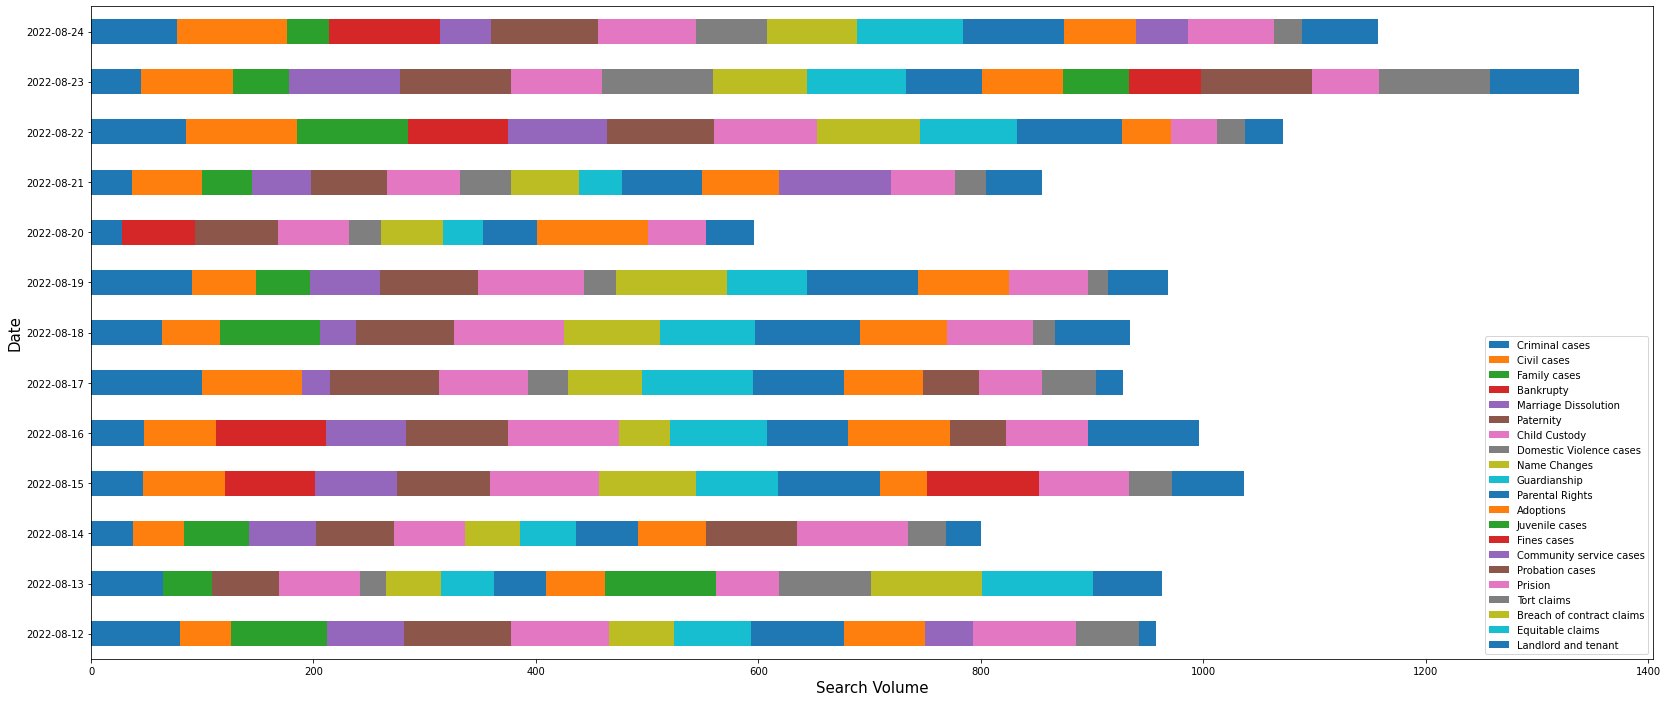

In [40]:
# 3. Get Search Volumns by using Search Google Trend
# Function
def google_trends(search, date_range):
    pytrends = TrendReq(hl="en-US", tz=360)
    kw_list = [search]
    try :
        pytrends.build_payload(kw_list, timeframe=date_range[0], geo='US')
        # Retrieve the interest Over time
        trends = pytrends.interest_over_time()
        #related_queries = pytrends.related_queries()
        
    except Exception as e:
        print("\nGoogle Search Trend retrieval failed.")
        print(e)
        return
    return trends


# last 2 weeks Google Trend
now = datetime.datetime.now()
two_week = now - relativedelta(days=16)
date_range = ["%s %s" % (two_week.strftime('%Y-%m-%d'), now.strftime('%Y-%m-%d'))]

# Search Dataframe
google_watch_hist = pd.DataFrame()
#search_query = [m + " case" for m in genre]
search_query = genre

for s in search_query:
    trend = google_trends(s, date_range)
    google_watch_hist[s] = trend[s].tolist()

google_watch_hist['date'] = trend.index.tolist()
google_watch_hist.set_index(pd.PeriodIndex(google_watch_hist.date, freq="D"), inplace=True)
google_watch_hist.drop('date', axis=1, inplace=True)

# Plot
google_watch_hist.plot(kind='barh', stacked=True, figsize=(28, 12))
plt.xlabel("Search Volume",  fontsize=15)
plt.ylabel("Date",  fontsize=15)
plt.legend()


# 4. Weight Formula
search_score = dict()

for g in genre:
    search_score[g] = stats.zscore(google_watch_hist[g])[-1]
x = np.asarray([val for key, val in search_score.items()])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

genre_weights = softmax(x)

# Weight Formula : w_i : genre_weight, x_i : encoded genre text
search_encoded_vector = np.asarray(sum([item * weight for item, weight in zip(items, genre_weights)]))
search_encoded_vector = search_encoded_vector.reshape((1, 768))

In [41]:
# 1. Get semantic outputs
print("******* Original Semantic Law Cases Search *******")
semantic_outputs, _ = law_bert.search(user_query = my_query, top_k = 10, index = index_1)
candidate_plots = [x['judgment_summary'] for x in semantic_outputs]
embeddings = law_bert.model.encode(candidate_plots)

# 2. Compute Cosine-sim for each sentence with search_vector
cosine_scores = util.pytorch_cos_sim(search_encoded_vector, embeddings)
for (i, score) in zip(semantic_outputs, cosine_scores.numpy()[0]):
    i['search_score'] = score

# 3. Sorting by search_score
online_outputs = sorted(semantic_outputs, key=lambda x: x['search_score'], reverse = True)

print("\n\n\n\n ******* Online-based Filtering ******* \n\n")
for i, out in enumerate(online_outputs):
   print("\n === Law Cases ===")
   print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

******* Original Semantic Law Cases Search *******

 === Calculate run time : 74.8253 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 구상금 (2000다67464)  
 | Cluster : 66 
 | Cluster's Topics (Keywords) : [('중앙선을', 0.15482084079007338), ('침범하여', 0.05802219073251441), ('중앙선', 0.056471706836761885), ('교통사고처리특례법', 0.04770557111668611), ('차선이', 0.04664047729783777), ('넘어선', 0.04304659528599706), ('도로의', 0.03910626128790208), ('설치된', 0.03397737102898379), ('경우를', 0.03383841310471702), ('도로교통법', 0.03205601187403954), ('운전자가', 0.031419732417493976), ('침범하였을', 0.028592946297478907), ('교통사고를', 0.028139078569375912), ('제3조', 0.028098065939036704), ('안전조치를', 0.0273309708268774), ('발생지점이', 0.025397516692733043), ('피하기', 0.02470994459251348), ('침범', 0.023649944819649594), ('부득이한', 0.023327387979498782), ('제2항', 0.02181985710595478)] 
 | Date : 20010209 | Judgment Issue : [1] 중앙선 침범 사고에서 자기 차선을 따라 운행한 자동차 운전자의 주의의무의 정도와 그의 과속운행을 과실로 볼 수 있는지 여부

### 4-4. Dynamic Poist-filtering result

In [42]:
print("\n")
print("\n >> Write your case :", my_query)
print("\n")

# Case name (Case number) : Judgment issue (cluster_name) 
results = pd.DataFrame()
results['Only Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in original_outputs]
results['Popularity-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in p_outputs]
results['User-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in user_outputs]
results['Online-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in online_outputs]
results




 >> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.




,Only Semantic Search,Popularity-based Semantic Search,User-based Semantic Search,Online-based Semantic Search
0,구상금 (2000다67464) : [1] 중앙선 침범 사고에서 자기 차선을 따라 운...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,자동차운송사업면허취소처분취소 (84누300) : 빗길에 과속으로 운행중 중앙분리선...,"특정범죄가중처벌등에관한법률위반,도로교통위반피고사건 (74노626) : 자동차운전사가..."
1,손해배상(자) (96다33808) : 고속도로 진행 중 돌발사태를 피하여 갓길로 급...,구상금 (2000다67464) : [1] 중앙선 침범 사고에서 자기 차선을 따라 운...,손해배상 (85다2184) : 가. 자신의 선행행위로 야기된 불가항력적 사유와 이를...,업무상과실치상 (82도3222) : 안전거리를 확보치 않은 차가 뒷차의 충격으로 ...
2,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...,손해배상(기) (2001나44354) : 자동차 운전자가 주취로 인하여 지각능력과 ...,업무상과실치상 (2009도2390) : [1] \n 교통사고처리 특...,손해배상(자) (96다33808) : 고속도로 진행 중 돌발사태를 피하여 갓길로 급...
3,업무상과실치상 (82도3222) : 안전거리를 확보치 않은 차가 뒷차의 충격으로 ...,손해배상(자) (96다33808) : 고속도로 진행 중 돌발사태를 피하여 갓길로 급...,도로교통법위반(음주운전) (2004노4281) : 피고인이 자동차의 히터를 가동하기...,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...
4,손해배상(자) (96다39837) : 승용차의 급차선 변경시 날아온 철판에 의하여 ...,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...,구상금 (2000다67464) : [1] 중앙선 침범 사고에서 자기 차선을 따라 운...,손해배상(자) (96다39837) : 승용차의 급차선 변경시 날아온 철판에 의하여 ...
5,"특정범죄가중처벌등에관한법률위반,도로교통위반피고사건 (74노626) : 자동차운전사가...",구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...,손해배상(기) (2001나44354) : 자동차 운전자가 주취로 인하여 지각능력과 ...,운수사업면허취소처분취소 (86누279) : 전방주시의무 소홀로 경부고속도로 주행선...
6,손해배상(기) (2001나44354) : 자동차 운전자가 주취로 인하여 지각능력과 ...,업무상과실치상 (82도3222) : 안전거리를 확보치 않은 차가 뒷차의 충격으로 ...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,구상금 (2000다67464) : [1] 중앙선 침범 사고에서 자기 차선을 따라 운...
7,운수사업면허취소처분취소 (86누279) : 전방주시의무 소홀로 경부고속도로 주행선...,손해배상(자) (96다39837) : 승용차의 급차선 변경시 날아온 철판에 의하여 ...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...
8,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...,"특정범죄가중처벌등에관한법률위반,도로교통위반피고사건 (74노626) : 자동차운전사가...",손해배상(자) (96다33808) : 고속도로 진행 중 돌발사태를 피하여 갓길로 급...,손해배상(기) (2001나44354) : 자동차 운전자가 주취로 인하여 지각능력과 ...
9,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,운수사업면허취소처분취소 (86누279) : 전방주시의무 소홀로 경부고속도로 주행선...,손해배상(자) (2005가단109544) : [1] 무보험자동차에 의한 상해 보험에...,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...
